# Multi-Variable Regression
---
Ideally this would produce some form of score prediction given various features.

In [1]:
import pandas as pd # DataFrame
df = pd.read_csv('../data/external/nfl_games.csv')
df = df[df.season >= 2000]
df.head()

,date,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,result1
11217,2000-09-03,2000,0,0,WSH,CAR,1537.928,1476.197,0.674700,20,17,1.0
11218,2000-09-03,2000,0,0,OAK,LAC,1529.383,1470.761,0.670760,9,6,1.0
11219,2000-09-03,2000,0,0,PIT,BAL,1450.365,1493.970,0.530751,0,16,0.0
11220,2000-09-03,2000,0,0,NYG,ARI,1459.851,1428.216,0.635590,21,16,1.0
11221,2000-09-03,2000,0,0,NE,TB,1499.712,1574.305,0.486198,16,21,0.0


Lets go ahead and remove anything that is not a target or a feature

In [2]:
df = df.drop(['date','result1'],1)
df.head()

,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2
11217,2000,0,0,WSH,CAR,1537.928,1476.197,0.674700,20,17
11218,2000,0,0,OAK,LAC,1529.383,1470.761,0.670760,9,6
11219,2000,0,0,PIT,BAL,1450.365,1493.970,0.530751,0,16
11220,2000,0,0,NYG,ARI,1459.851,1428.216,0.635590,21,16
11221,2000,0,0,NE,TB,1499.712,1574.305,0.486198,16,21


In [3]:
home = df.drop(['team2','score2','elo2'],1)
away = df.drop(['team1','score1','elo1'],1)

In [4]:
home.head()

,season,neutral,playoff,team1,elo1,elo_prob1,score1
11217,2000,0,0,WSH,1537.928,0.674700,20
11218,2000,0,0,OAK,1529.383,0.670760,9
11219,2000,0,0,PIT,1450.365,0.530751,0
11220,2000,0,0,NYG,1459.851,0.635590,21
11221,2000,0,0,NE,1499.712,0.486198,16


In [5]:
away.head()

,season,neutral,playoff,team2,elo2,elo_prob1,score2
11217,2000,0,0,CAR,1476.197,0.674700,17
11218,2000,0,0,LAC,1470.761,0.670760,6
11219,2000,0,0,BAL,1493.970,0.530751,16
11220,2000,0,0,ARI,1428.216,0.635590,16
11221,2000,0,0,TB,1574.305,0.486198,21


We will rejoin the away and home dataframes with a new column "Home" where its value will be 1 if its Team1 and 0 if its Team2

In [6]:
home['Home'] = 1
away['Home'] = 0
home.rename(columns = {'team1':'team','elo1':'elo','elo_prob1':'elo_prob','score1':'score'}, inplace = True)
away.columns = home.columns
df = home.append(away)

In [7]:
df.isnull().sum()
df.head()

,season,neutral,playoff,team,elo,elo_prob,score,Home
11217,2000,0,0,WSH,1537.928,0.674700,20,1
11218,2000,0,0,OAK,1529.383,0.670760,9,1
11219,2000,0,0,PIT,1450.365,0.530751,0,1
11220,2000,0,0,NYG,1459.851,0.635590,21,1
11221,2000,0,0,NE,1499.712,0.486198,16,1


I've taken the values down to just 1 team 1 score with a binary value representing whether it was a home or away game. This is under the assumption that Team1 is the home team and Team2 is the away team. Verified that there is no NaN values in the DataFrame. Now I need to convert the teams to one-hot encoding.

In [8]:
one_hot_teams = pd.get_dummies(df['team'])
# Drop column as it is now encoded
df = df.drop('team',axis = 1)
# Join the encoded df
df = df.join(one_hot_teams)
df.head()

,season,neutral,playoff,elo,elo_prob,score,Home,ARI,ATL,BAL,...,NYG,NYJ,OAK,PHI,PIT,SEA,SF,TB,TEN,WSH
11217,2000,0,0,1537.928,0.67470,20,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11217,2000,0,0,1537.928,0.67470,20,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11217,2000,0,0,1476.197,0.67470,17,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11217,2000,0,0,1476.197,0.67470,17,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11218,2000,0,0,1529.383,0.67076,9,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


MinMax normalizing the seasons and elo will help with fitting before using for modeling. Removing the target y value, score, so I can normalize all of the x values.

In [9]:
from sklearn import preprocessing #Normalization
y = df.score
scaler = preprocessing.MinMaxScaler()
x = df.drop('score',1)
x_scaled = scaler.fit_transform(x)
x = pd.DataFrame(x_scaled, columns=x.columns)
x.head()

,season,neutral,playoff,elo,elo_prob,Home,ARI,ATL,BAL,BUF,...,NYG,NYJ,OAK,PHI,PIT,SEA,SF,TB,TEN,WSH
0,0.0,0.0,0.0,0.519146,0.661780,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.519146,0.661780,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.423871,0.661780,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.423871,0.661780,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.505958,0.657183,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
y.head()

11217    20
11217    20
11217    17
11217    17
11218     9
Name: score, dtype: int64

With target values generated and features ready for training, start the linear regression modelling

In [16]:
from sklearn.model_selection import train_test_split #train_test_split
from sklearn.linear_model import LinearRegression
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
model_lr = LinearRegression()  
model_lr.fit(x_train, y_train)
y_pred = model_lr.predict(x_test)
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [17]:
results

,Actual,Predicted
12878,13,27.795548
16246,27,20.882834
15984,10,19.583780
13761,3,23.659607
12960,0,19.492647
...,...,...
12621,27,22.736164
11830,23,16.831379
12638,15,17.461761
11928,27,23.030360


Plotting the actual vs predicted values on a bar graph to get a general idea of the error in predictions

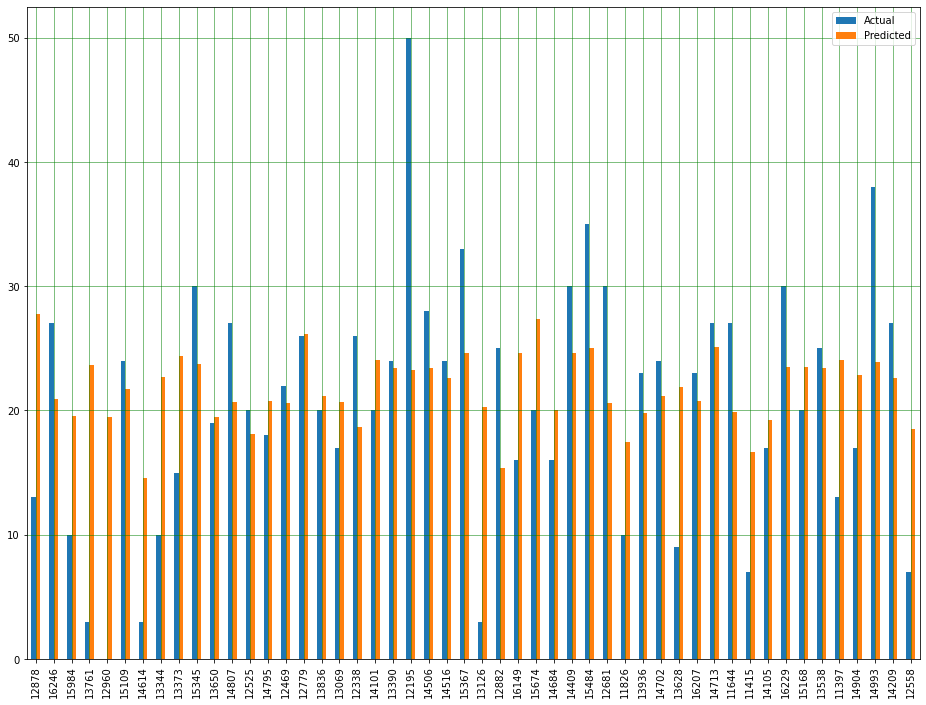

In [21]:
import matplotlib.pyplot as plt
results.head(50).plot(kind='bar',figsize=(16, 12))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [23]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean of Scores:', y.mean())

Mean Absolute Error: 7.811776528972671
Mean of Scores: 21.886790587304727


Well that's unfortunate. With a Mean Absolute Error greater than 30% of the overall scores mean the model does not look very accurate.

# Conclusion
---
Unfortunately I could not feasibly define a way to perform linear regression while using both team names as a factor in scores. For example I was hoping that a team who did well when playing against another team that did well would most likely score low as they would be more evenly matched. In future models it would be key to model the relation of teams and their opponents as this model considered solely a single team and the aspects around them with no correlation to their opponent.